In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

from libworm.model.beta_neuron import NeuronNetwork, from_connectome
from libworm.data import connectomes, traces
from libworm import preprocess
from libworm.functions import set_neurons, tcalc_s_inf, set_trace
from libworm.data.neuron import full_sensory_list

import json

from math import tau

In [3]:
_, trace, trace_labels, label2index, timestamps = traces.load_trace()
timestamps = timestamps - timestamps[0]

chemical, gapjn = connectomes.load_cook_connectome()
neurons = connectomes.get_main_neurons(chemical, gapjn)
neurons.sort(key=lambda item: f"AAA{label2index[item]:04d}{item}" if item in label2index else item)

not_in_main_section = [label2index[key] for key in label2index if key not in neurons]
not_labelled = [i for i, _ in enumerate(trace[:, 0]) if i not in label2index.values()]

removal = list(set(not_in_main_section).union(not_labelled))

trace = np.delete(trace, removal, axis=0)

In [4]:
with open("rust/results/d_bio_sens_dt_00001.json", "r") as file:
    small = np.array(json.load(file))

with open("rust/results/d_bio_sens_dt_001.json", "r") as file:
    med = np.array(json.load(file))

with open("rust/results/d_bio_sens_dt_01.json", "r") as file:
    large = np.array(json.load(file))

with open("rust/results/d_bio_sens_dt_1.json", "r") as file:
    huge = np.array(json.load(file))

with open("rust/processed_data/sensory_indices.json", "r") as file:
    sensory_indices = json.load(file)

datas = [small, med, large, huge]

In [5]:
def side_comp(datas, count = 32, per = 8, stride=1, ymin=-50, ymax=5, show_sens=True):

    rows = int(np.ceil(count / per))

    fig, axs = plt.subplots(ncols=len(datas), nrows=rows, figsize=(5*12, 5*12))

    for ax in axs.flatten().tolist():
        ax.set_ylim([ymin, ymax])

    ax_index = -1
    
    # Voltage time curves
    for i in range(count):
        if i % per == 0:
            ax_index += 1
        for j, data in enumerate(datas): 
            if i in sensory_indices:
                if show_sens:
                    axs[ax_index, j].plot(data[::stride, i], label=f'V_m_{i}', marker='^')
                else:
                    pass
            else:
                axs[ax_index, j].plot(data[::stride, i], label=f'V_m_{i}')
            
        
    plt.show()

In [6]:
def show_large_voltage_data(data, count = None, per = 8.0, stride=1):
    
    if count is None:
        pass
    else:
        data = data[:, :count]

    size = int(np.ceil(np.sqrt(data.shape[1] / per)))

    fig, axs = plt.subplots(ncols=size, nrows=size, figsize=(5*12, 5*12))

    ax_index = -1
    
    # Voltage time curves
    for i in range(data.shape[1]):
        if i % per == 0:
            ax_index += 1

        if i in sensory_indices:
            axs[ax_index // size, ax_index % size].plot(data[::stride, i], label=f'V_m_{i}', marker='^')
        else:
            axs[ax_index // size, ax_index % size].plot(data[::stride, i], label=f'V_m_{i}')
        
        
    plt.show()

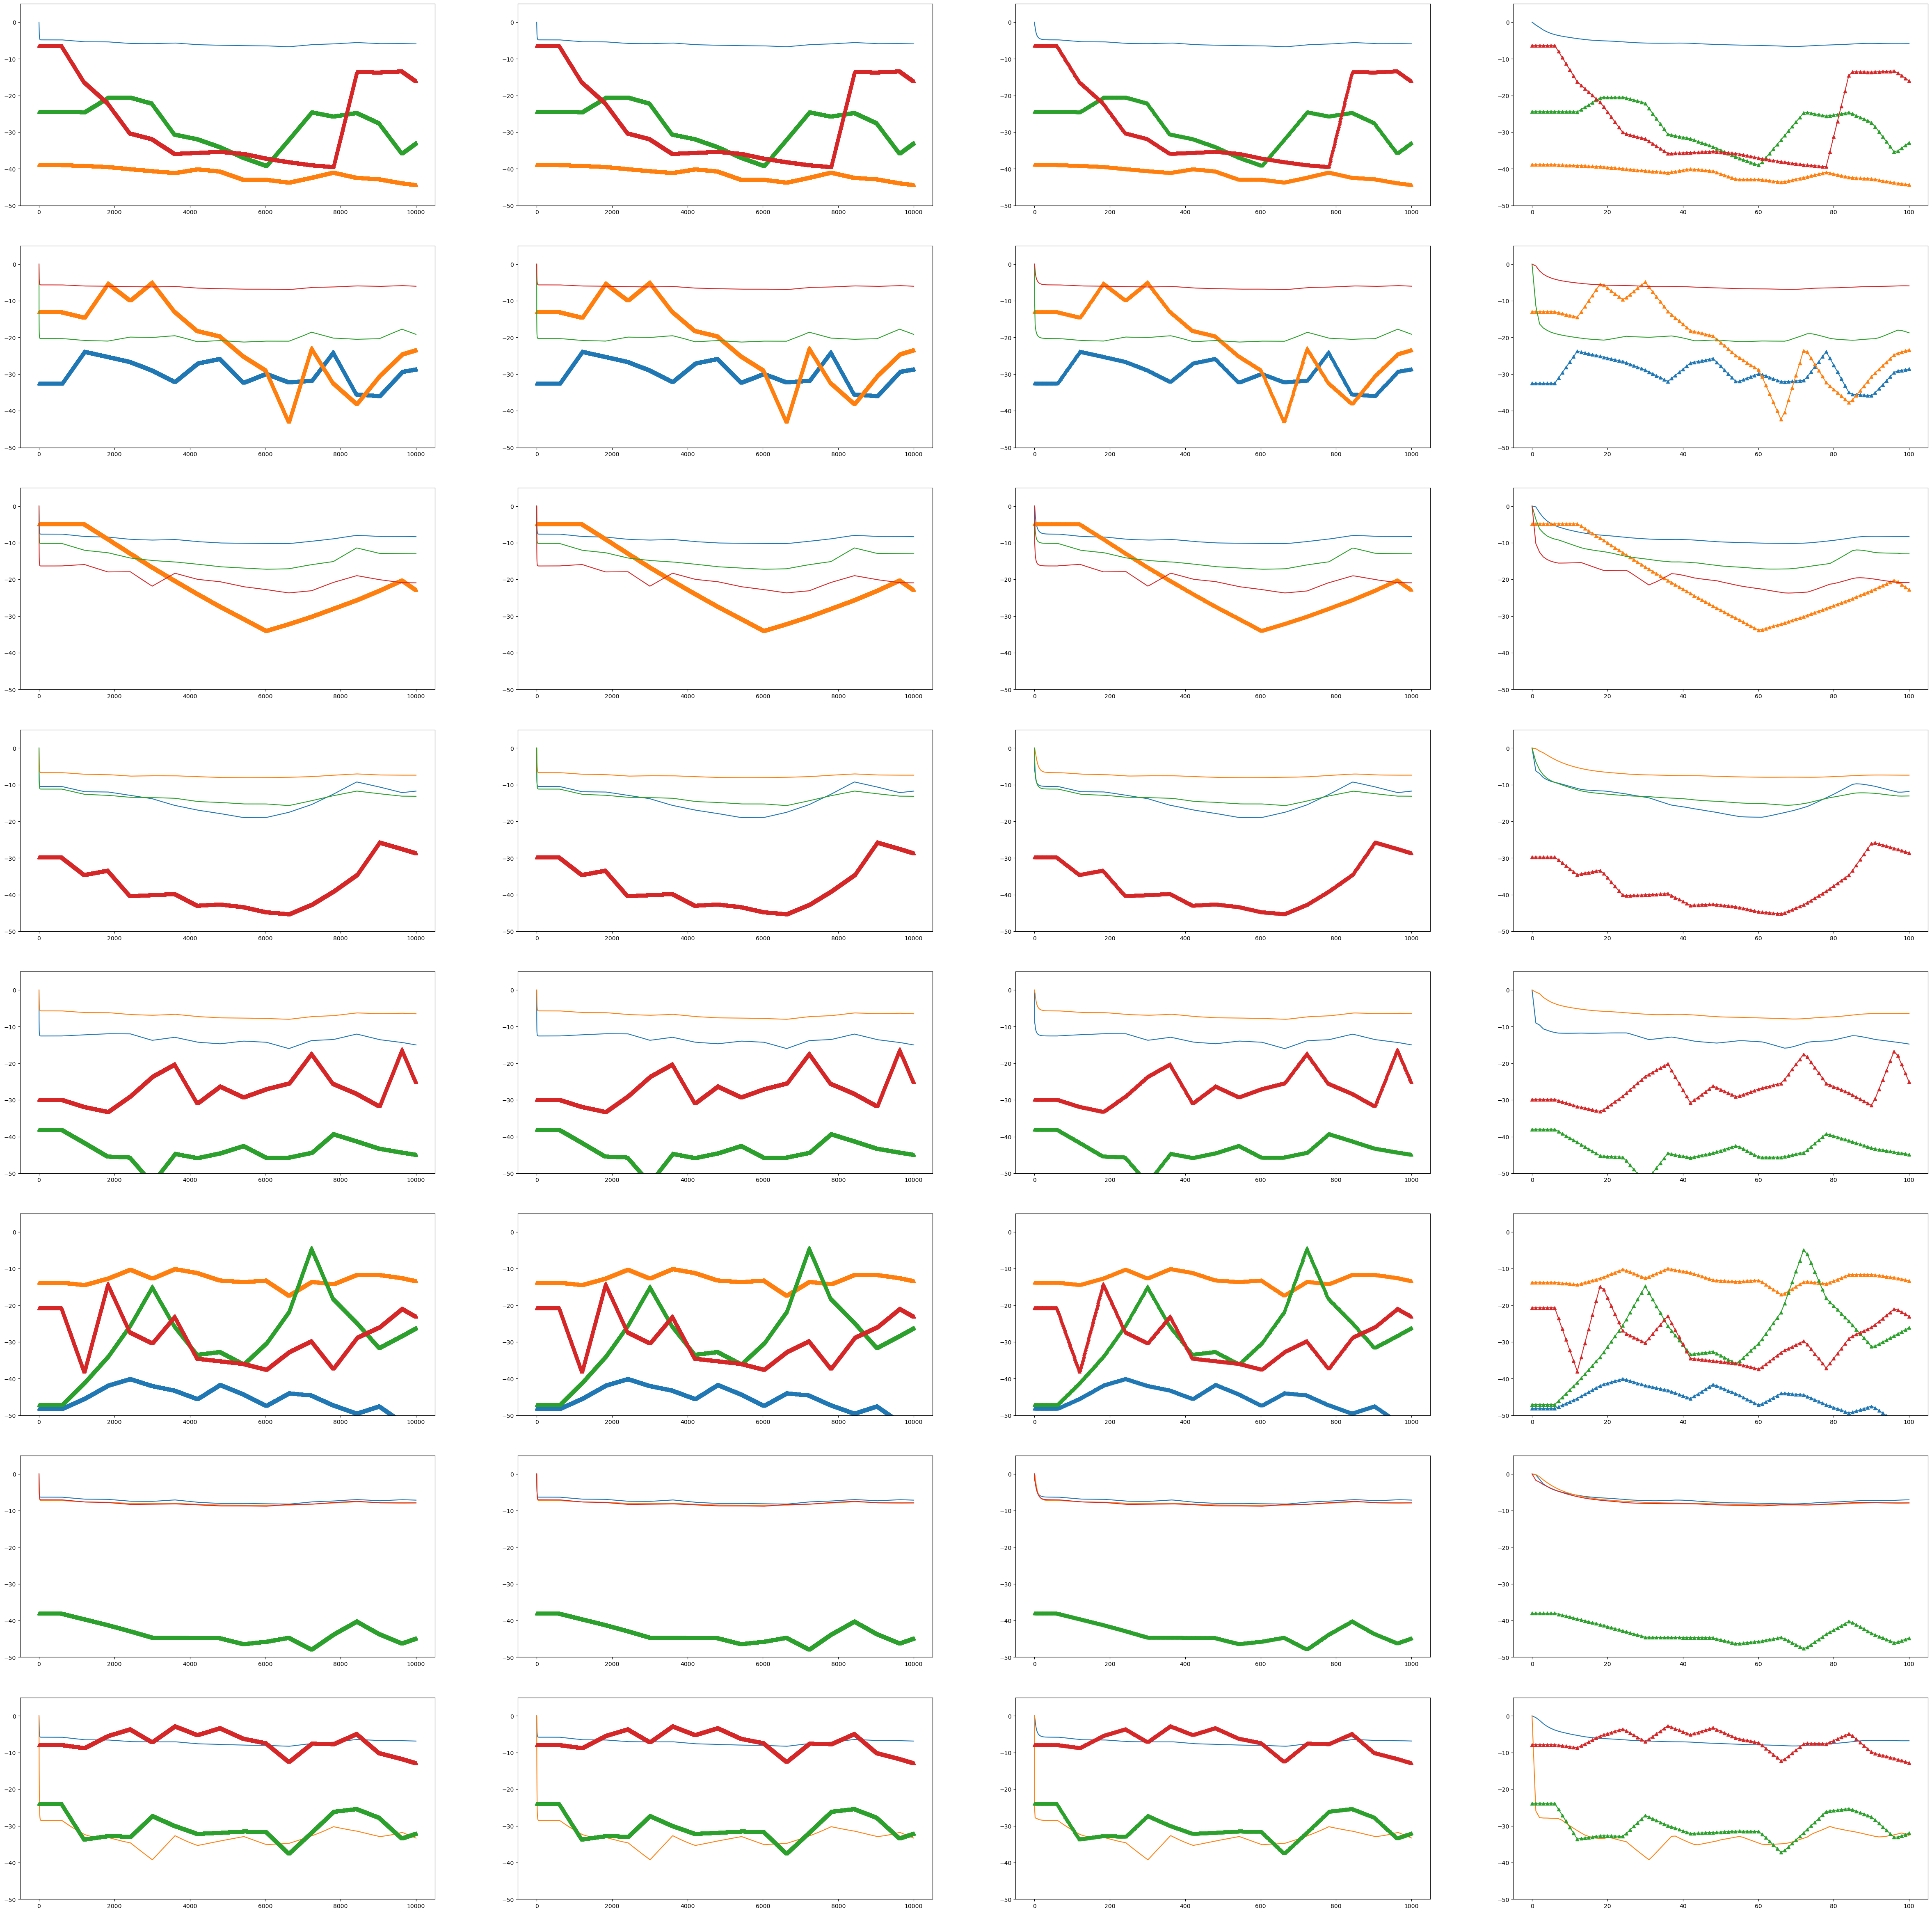

In [16]:
side_comp(datas, per=4)

In [117]:
trace.shape

(152, 1600)

In [118]:
small.shape

(10001, 280)

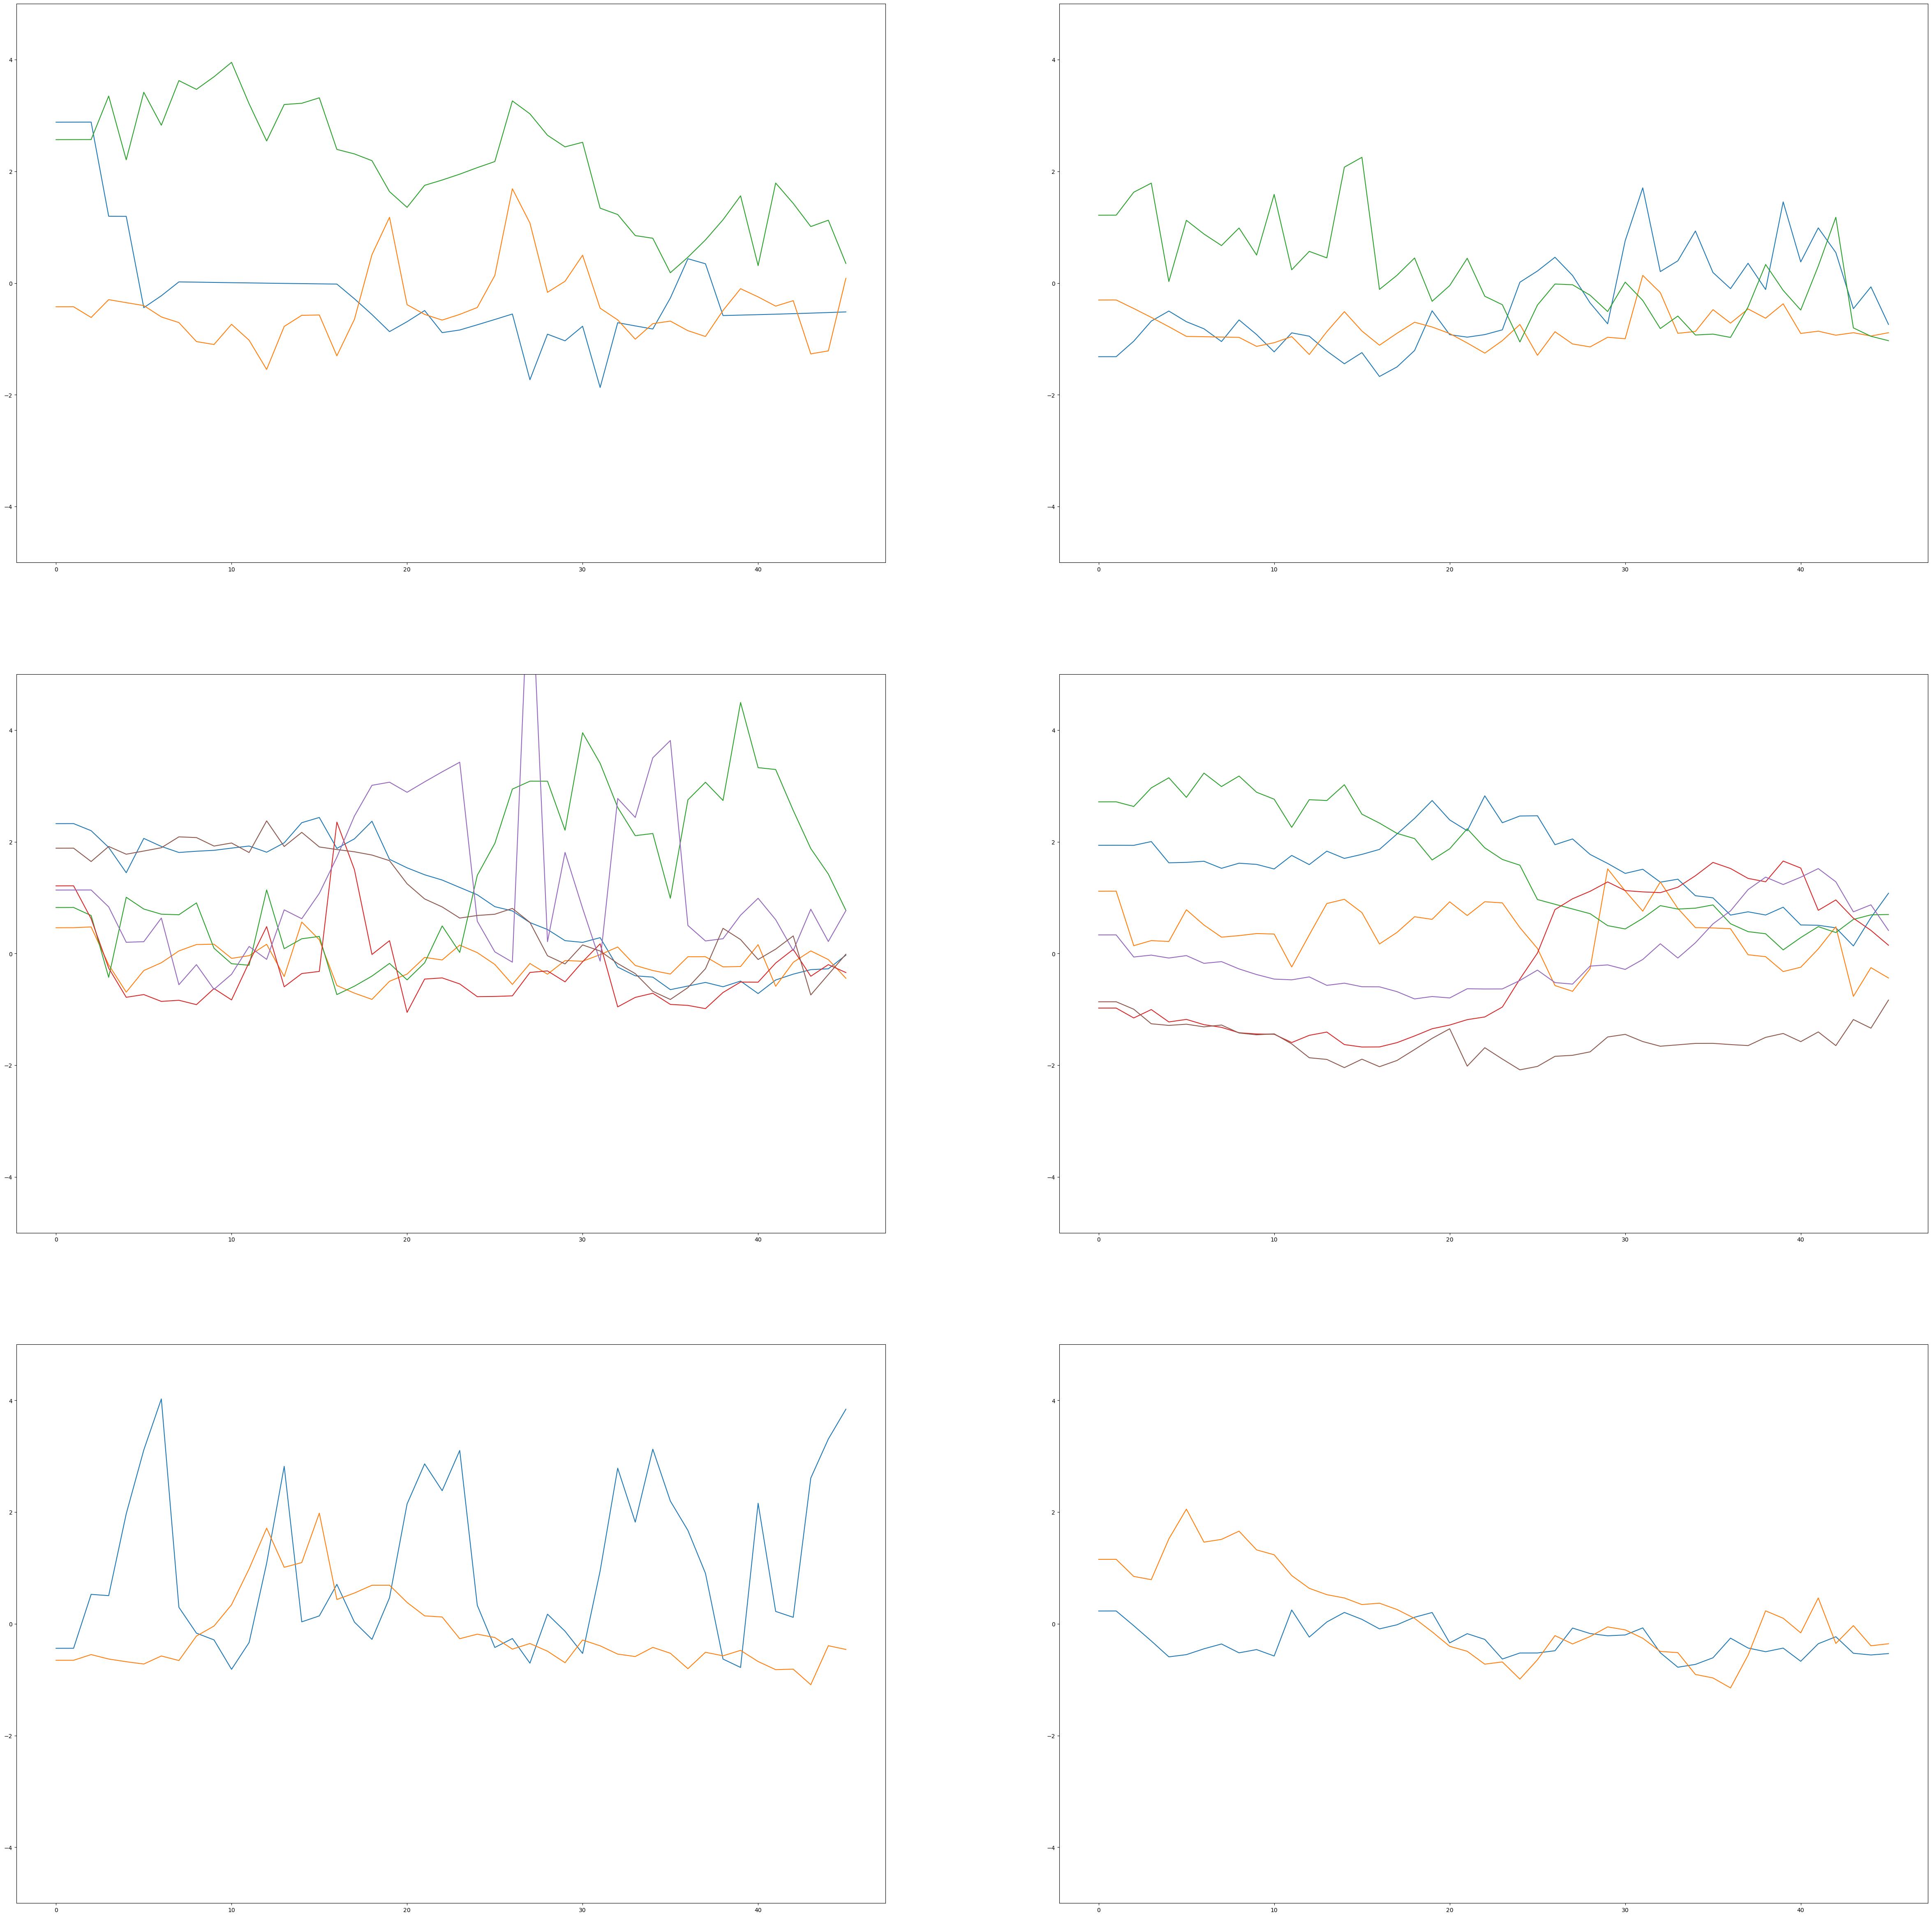

In [64]:
side_comp([trace.T[:46, 0:20], trace.T[:46, 20:40]], count=20, ymin=-5, ymax=5, show_sens=False)

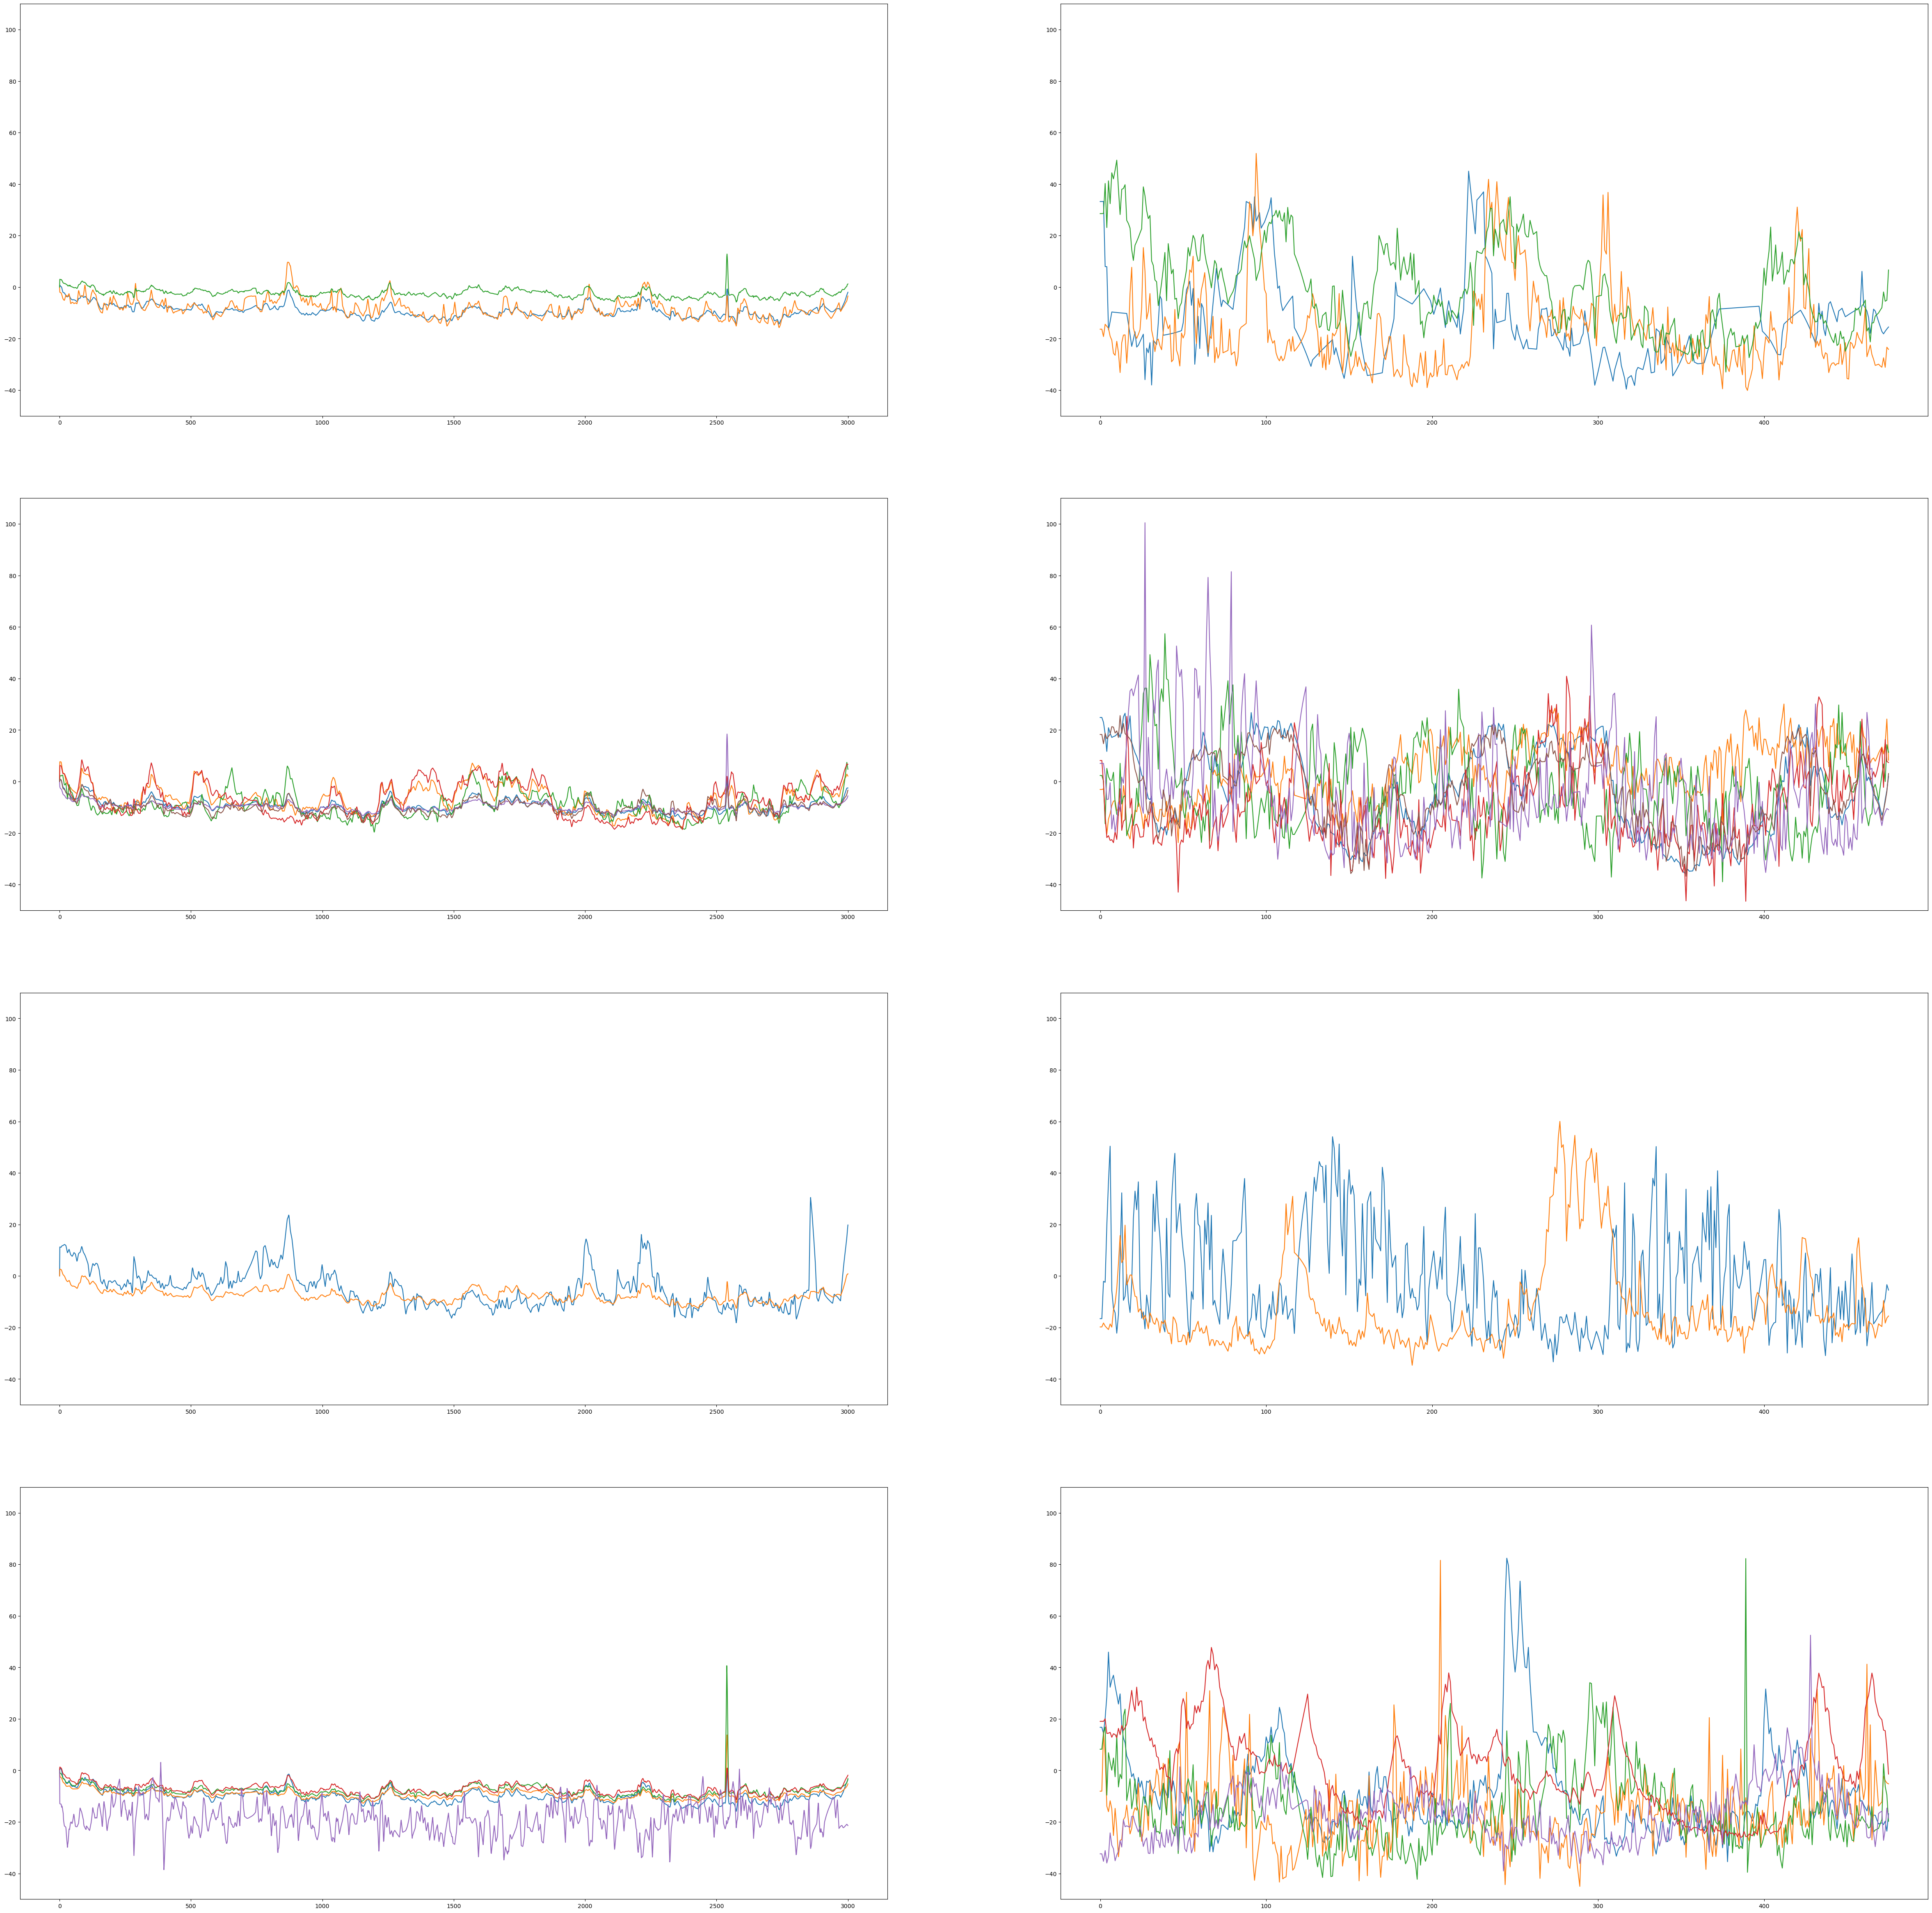

In [9]:
# prev_data = data

with open("rust/results/evolved_run_without_gates.json", "r") as file:
    data = np.array(json.load(file))

mod_trace = 15.0 * trace.T[:476, :] - 10.0

side_comp([data, mod_trace], ymax=110, show_sens=False)

In [18]:
with open("rust/results/correct_trace_processing.json", "r") as file:
    data = np.array(json.load(file))

data = np.nan_to_num(data.astype(np.float64), nan=5000)

In [19]:
data[:, 2]

array([3471.14997217, 3470.43104891, 3469.73799232, ..., 5868.07335519,
       5897.66842077, 5927.43706143])

In [20]:
data[22487]

array([  12.        ,  -13.        , 3309.51896052])

In [21]:
data[:, 2].max()

9158471.555543434

In [22]:
data[:, 2].argmin()

22487

In [23]:
data[:, 2].min()

3309.518960516862

In [24]:
slice = data[:, 2].reshape(200, 200)
slice.shape

(200, 200)

In [25]:
slice

array([[3471.14997217, 3470.43104891, 3469.73799232, ..., 3543.78190493,
        3549.29582962, 3554.96383933],
       [3471.67667846, 3470.92892164, 3470.20874776, ..., 3549.75768227,
        3555.48774943, 3561.37590846],
       [3472.2325648 , 3471.45433303, 3470.70529211, ..., 3556.0226594 ,
        3561.97763366, 3568.09488167],
       ...,
       [3418.95966864, 3416.11367176, 3413.37109952, ..., 5929.12436944,
        5959.69825146, 5990.45291119],
       [3416.27863935, 3413.56728357, 3410.95839334, ..., 5898.19421199,
        5928.27182906, 5958.52657285],
       [3413.75936982, 3411.17868104, 3408.69945065, ..., 5868.07335519,
        5897.66842077, 5927.43706143]])

<Axes: >

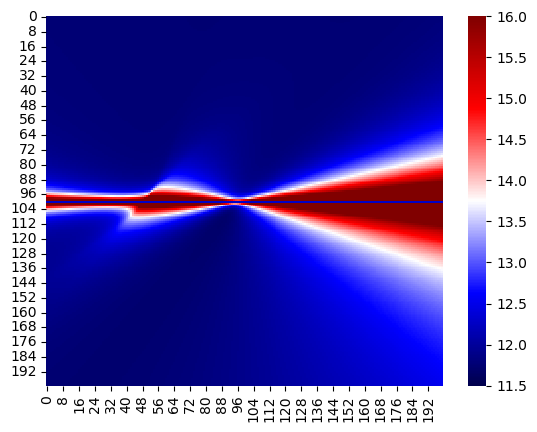

In [36]:
log_proc = np.log2(slice)

sns.heatmap(log_proc, vmin=11.5, vmax=16, cmap="seismic")